In [1]:
%cd "/content/drive/MyDrive/fashionGans"

/content/drive/MyDrive/fashionGans


In [2]:
pwd

'/content/drive/MyDrive/fashionGans'

In [3]:
from keras.models import Model, Sequential
from keras.layers import Dense , Activation, Reshape, BatchNormalization , Input
from keras.layers import Conv2D ,UpSampling2D , ELU, Flatten , Dropout , MaxPooling2D
from keras.optimizers import Adam , RMSprop
from keras.datasets import fashion_mnist

import numpy as np
import os 
from PIL import Image
import matplotlib.pyplot as plt

In [4]:
#real data 
(x_train, y_train), (x_test , y_test) = fashion_mnist.load_data() 

4431872/4422102 [==============================] - 0s 0us/step


In [5]:
print("x train shape : " ,x_train.shape)
print("y train shape :", y_train.shape)

x train shape :  (60000, 28, 28)
y train shape : (60000,)


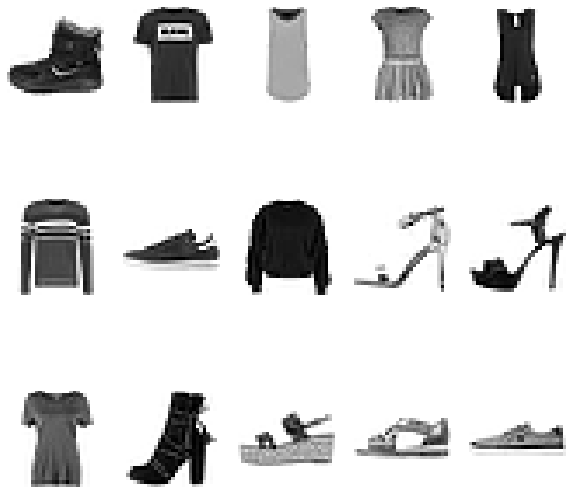

In [6]:
#visualize
plt.figure(figsize=(10,10))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.axis("off")    
plt.show()

In [7]:
#preprocessing
real_data = x_train.astype(np.float32)
real_data = (real_data - 127.5) / 127.5 
real_data = real_data.reshape(x_train.shape[0] ,x_train.shape[1], x_train.shape[2], 1)
print("real data shape : ",real_data.shape)

real data shape :  (60000, 28, 28, 1)


In [8]:
#üretec
def generator(input_dim = 100):
    
    model = Sequential()
    model.add(Dense(2048, input_dim = input_dim))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    model.add(Dense(7*7*256))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    model.add(Reshape((7,7,256), input_shape = (7*7*256,)))
    model.add(UpSampling2D((2,2)))
    
    model.add(Conv2D(64 , (3,3) , padding = "same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    model.add(UpSampling2D((2,2)))
    
    model.add(Conv2D(1 , (3,3), padding = "same"))
    model.add(Activation("tanh"))
    
    model.compile(loss = "binary_crossentropy" , optimizer = Adam(learning_rate=0.0002 , beta_1=0.5))
    
    return model
    
gen = generator()
gen.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              206848    
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
activation (Activation)      (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 12544)             1

In [9]:
#ayırt edici

def discriminator (input_shape = (28,28,1)):
    
    model = Sequential()
    model.add(Conv2D(64 , (5,5), padding = "same" , input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D((2,2)))
    
    
    model.add(Conv2D(128 , (5,5), strides = (2,2) ))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D((2,2)))
    
   
    model.add(Flatten())
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.add(Activation("sigmoid"))
    
    model.compile(loss = "binary_crossentropy" , optimizer = "adam")
    
    return model

dis = discriminator()
dis.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
batch_normalization_4 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
activation_5 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 128)         204928    
_________________________________________________________________
batch_normalization_5 (Batch (None, 5, 5, 128)         512       
_________________________________________________________________
activation_6 (Activation)    (None, 5, 5, 128)        

In [10]:
#gans
def gans(g , d,input_dim = 100):
    
    d.trainable = False
    gan_input = Input(shape = input_dim)
    x = g(gan_input)
    gan_output = d(x)
    
    modelGans = Model(inputs = gan_input , outputs = gan_output)
    modelGans.compile(loss = "binary_crossentropy" , optimizer = "adam")
    
    return modelGans

gan = gans(gen, dis)
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         15373441  
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 604673    
Total params: 15,978,114
Trainable params: 15,342,081
Non-trainable params: 636,033
_________________________________________________________________


In [12]:
batch_size = 256
epoch =  200
num_batch_size = 128

In [13]:
#train
for e in range(epoch):
    
    for i in range(num_batch_size):
    
        #gen input 100
        noise = np.random.normal(0 , 1, [batch_size,100])
        generator_images = gen.predict(noise) # 28,28,1

        #real data
        #image_batch = real_data[i*batch_size:(i+1)*batch_size] # 28,28,1
        #random choose
        image_batch = real_data[np.random.randint(low = 0,
                                                  high = real_data.shape[0],
                                                  size = batch_size)]

        #real data vs fake data
        x = np.concatenate([image_batch , generator_images])
        y_dis = np.zeros(batch_size*2)
        y_dis[:batch_size] = 1

        #dis train
        dis.trainable = True
        dis.train_on_batch(x, y_dis)

        #gen train
        noise = np.random.normal(0 , 1, [batch_size,100])
        y_gen = np.ones(batch_size)

        dis.trainable = False

        gan.train_on_batch(noise , y_gen)
        

    if(e == 49 or e == 99 or e == 149):
        
        a = str(e)
        #save
        gen.save_weights("modelFashion"+a+".h5")
        
    if e % 10 == 0:
        print("Epoch : " ,e)     
    
#save            
gen.save_weights("modelFashion.h5")    


Epoch :  0
Epoch :  10
Epoch :  20
Epoch :  30
Epoch :  40
Epoch :  50
Epoch :  60
Epoch :  70
Epoch :  80
Epoch :  90
Epoch :  100
Epoch :  110
Epoch :  120
Epoch :  130
Epoch :  140
Epoch :  150
Epoch :  160
Epoch :  170
Epoch :  180
Epoch :  190
